# Diabetic step response
## Glucose-Oligomycin-FCCP protocol

Step responses to both glucose stimulation and chemical agents (I)

In [1]:
using DifferentialEquations
using ModelingToolkit
using MitochondrialDynamics
using MitochondrialDynamics: second, μM, mV, mM, Hz, minute
import PythonPlot as plt
plt.matplotlib.rcParams["font.size"] = 14

14

In [2]:
@named sys = make_model()
@unpack GlcConst, rPDH, rETC, rHL, rF1 = sys

tend = 80minute
ts = range(0, tend, 401)
tspan = (ts[begin], ts[end])
alg = TRBDF2()
prob = ODEProblem(sys, [], tspan)
prob_dm = ODEProblem(sys, [], tspan, [rPDH=>0.5, rETC=>0.75, rHL=>1.4, rF1=>0.5])

ssprob_dm = SteadyStateProblem(prob_dm)
sssol_dm = solve(ssprob_dm, DynamicSS(Rodas5()))

retcode: Success
u: 9-element Vector{Float64}:
 0.07368627719724155
 0.0010463254441091614
 0.00021185849069846322
 0.09765785217335553
 0.002777775860824651
 0.026119126526252093
 0.8088327873830643
 0.22161263652025473
 0.036941795682897516

Define events

In [3]:
function add_glucose!(i)
    i.ps[GlcConst] = 20mM
end

add_glucose_cb = PresetTimeCallback(20minute, add_glucose!)

function add_oligomycin!(i)
    i.ps[rF1] *= 0.1
end

add_oligomycin_cb = PresetTimeCallback(40minute, add_oligomycin!)

function add_rotenone!(i)
    i.ps[rETC] *= 0.1
end

add_rotenone_cb = PresetTimeCallback(60minute, add_rotenone!)

function add_fccp!(i)
    i.ps[rHL] *= 5
end

add_fccp_cb = PresetTimeCallback(60minute, add_fccp!)

prob_dm = remake(prob_dm, u0=sssol_dm.u)
cbs = CallbackSet(add_glucose_cb, add_oligomycin_cb, add_fccp_cb)
sols3 = solve(prob, alg; callback=cbs, saveat=ts)
solDMs3 = solve(prob_dm, alg; callback=cbs, saveat=ts);

In [4]:
function plot_figs2(sol, solDM; figsize=(14, 10), labels=["Baseline", "Diabetic"], jo2_mul=t->1, laststep="FCCP")
    @unpack G3P, Pyr, NADH_c, NADH_m, Ca_c, Ca_m, ATP_c, ADP_c, ΔΨm, degavg, J_O2 = sol.prob.f.sys
    ts = sol.t
    tsm = ts ./ 60

    jo2 = sol[J_O2 * 1000] .* jo2_mul.(ts)
    pyr = sol[Pyr * 1000]
    nadh_c = sol[NADH_c * 1000]
    nadh_m = sol[NADH_m * 1000]
    ca_c = sol[Ca_c * 1000]
    ca_m = sol[Ca_m * 1000]
    td = sol[ATP_c/ADP_c]
    dpsi = sol[ΔΨm * 1000]
    k = sol[degavg]

    pyrDM = solDM[Pyr * 1000]
    jo2DM = solDM[J_O2 * 1000] .* jo2_mul.(ts)
    nadh_cDM = solDM[NADH_c * 1000]
    nadh_mDM = solDM[NADH_m * 1000]
    ca_cDM = solDM[Ca_c * 1000]
    ca_mDM = solDM[Ca_m * 1000]
    tdDM = solDM[ATP_c/ADP_c]
    dpsiDM = solDM[ΔΨm * 1000]
    kDM = solDM[degavg]

    numrows = 3
    numcols = 3
    fig, ax = plt.subplots(numrows, numcols; figsize)

    ax[0, 0].plot(tsm, jo2, label=labels[1])
    ax[0, 0].plot(tsm, jo2DM, label=labels[2])
    ax[0, 0].set(ylabel="OCR (μM/s)")
    ax[0, 0].set_title("a", loc="left")
    ax[0, 0].legend(loc="lower right")
    ax[0, 0].annotate("Glc", xy=(20, 65), xytext=(20, 72),
        arrowprops=Dict("shrink"=>3, "facecolor"=>"black"))
    ax[0, 0].annotate("Omy", xy=(40, 65), xytext=(40, 72),
        arrowprops=Dict("shrink"=>3, "facecolor"=>"black"))
    ax[0, 0].annotate(laststep, xy=(60, 65), xytext=(60, 72),
        arrowprops=Dict("shrink"=>3, "facecolor"=>"black"))

    ax[0, 1].plot(tsm, pyr, label=labels[1])
    ax[0, 1].plot(tsm, pyrDM, label=labels[2])
    ax[0, 1].set(ylabel="Pyruvate (μM)")
    ax[0, 1].set_title("b", loc="left")

    ax[0, 2].plot(tsm, nadh_c, label=labels[1])
    ax[0, 2].plot(tsm, nadh_cDM, label=labels[2])
    ax[0, 2].set(ylabel="Cytosolic NADH (μM)")
    ax[0, 2].set_title("c", loc="left")

    ax[1, 0].plot(tsm, nadh_m, label=labels[1])
    ax[1, 0].plot(tsm, nadh_mDM, label=labels[2])
    ax[1, 0].set(ylabel="Mitochondrial NADH (μM)")
    ax[1, 0].set_title("d", loc="left")

    ax[1, 1].plot(tsm, ca_c, label=labels[1])
    ax[1, 1].plot(tsm, ca_cDM, label=labels[2])
    ax[1, 1].set(ylabel="Cytosolic Calcium (μM)")
    ax[1, 1].set_title("e", loc="left")

    ax[1, 2].plot(tsm, ca_m, label=labels[1])
    ax[1, 2].plot(tsm, ca_mDM, label=labels[2])
    ax[1, 2].set(ylabel="Mitochondrial Calcium (μM)")
    ax[1, 2].set_title("f", loc="left")

    ax[2, 0].plot(tsm, td, label=labels[1])
    ax[2, 0].plot(tsm, tdDM, label=labels[2])
    ax[2, 0].set(ylabel="ATP:ADP (ratio)", xlabel="Time (min)")
    ax[2, 0].set_title("g", loc="left")

    ax[2, 1].plot(tsm, dpsi, label=labels[1])
    ax[2, 1].plot(tsm, dpsiDM, label=labels[2])
    ax[2, 1].set(ylabel="ΔΨm (mV)", xlabel="Time (min)")
    ax[2, 1].set_title("h", loc="left")

    ax[2, 2].plot(tsm, k, label=labels[1])
    ax[2, 2].plot(tsm, kDM, label=labels[2])
    ax[2, 2].set(ylabel="Average Node Degree (a.u.)", xlabel="Time (min)")
    ax[2, 2].set_title("i", loc="left")

    for i in 0:numrows-1, j in 0:numcols-1
        ax[i, j].legend()
        ax[i, j].grid()
    end

    fig.tight_layout()
    return fig
end

plot_figs2 (generic function with 1 method)

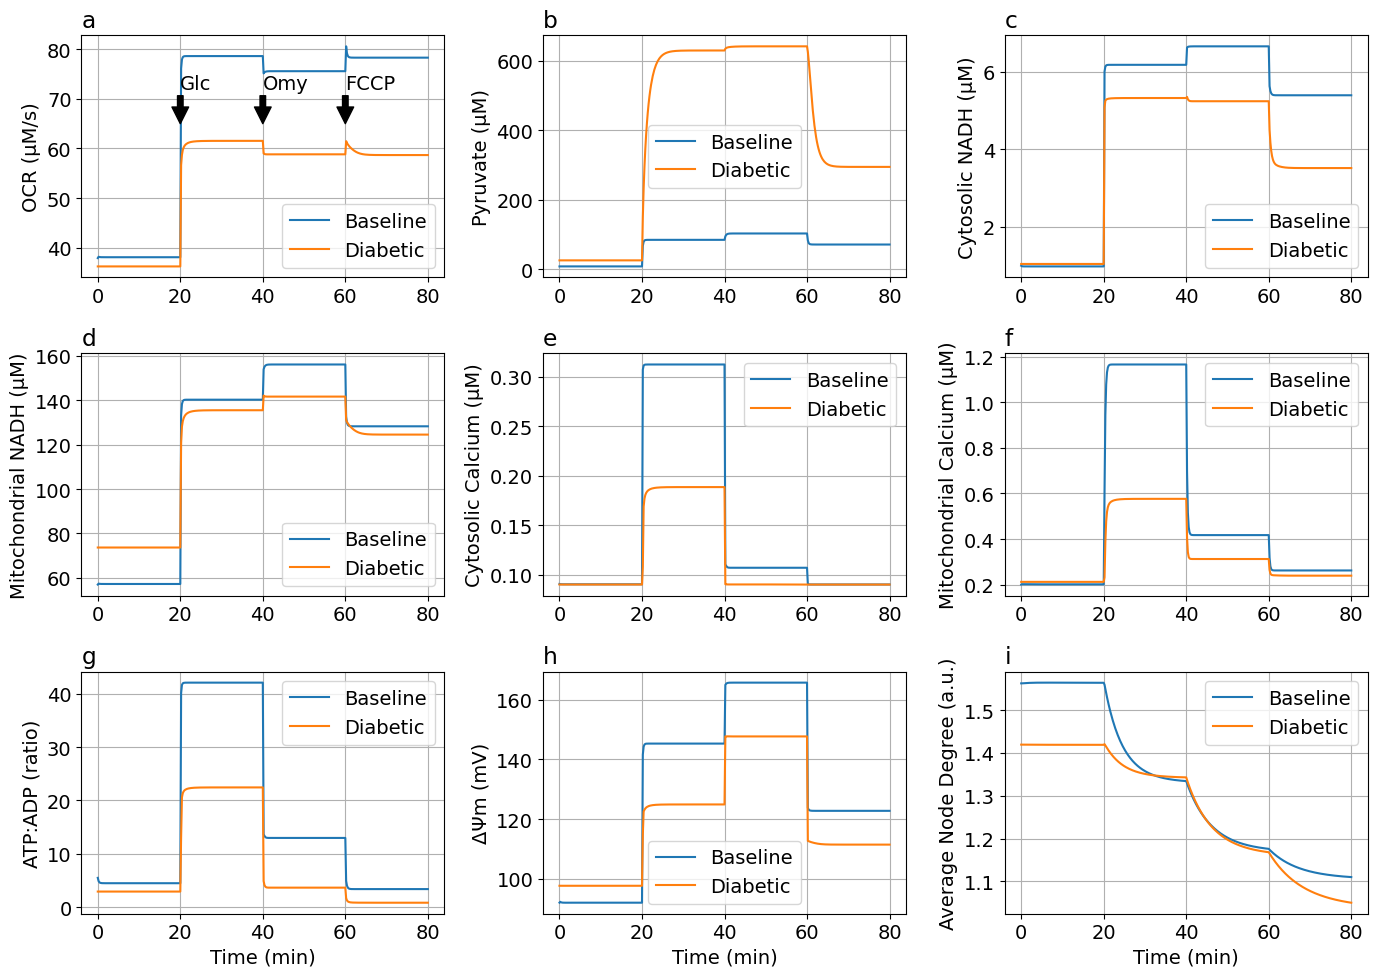

In [5]:
figs3 = plot_figs2(sols3, solDMs3)

TIFF file

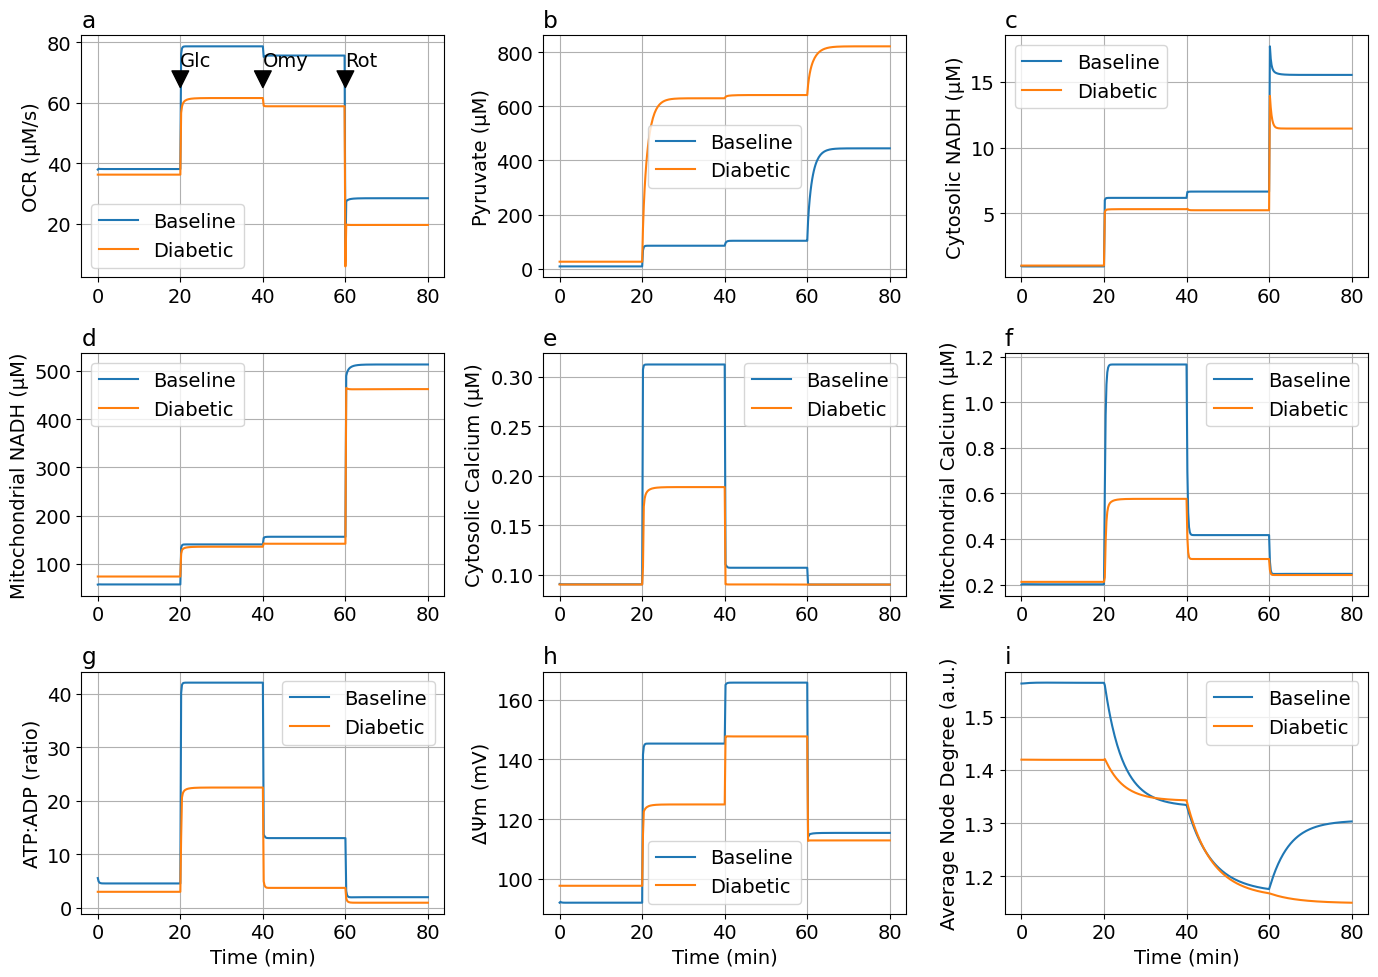

In [6]:
exportTIF(figs3, "FigDM-Glucose-Oligomycin-FCCP.tif")

# Glucose-Oligomycin-Rotenone
prob5 = ODEProblem(sys, [], tspan)
prob_dm5 = ODEProblem(sys, sssol_dm.u, tspan, [rPDH=>0.5, rETC=>0.75, rHL=>1.4, rF1=>0.5])
cbs = CallbackSet(add_glucose_cb, add_oligomycin_cb, add_rotenone_cb)
sols5 = solve(prob5, alg; callback=cbs, saveat=ts)
sols5DM = solve(prob_dm5, alg; callback=cbs, saveat=ts)

jo2_mul = t -> 10 - 9 * (t>=60minute)
figs5 = plot_figs2(sols5, sols5DM; jo2_mul, laststep="Rot")

In [7]:
exportTIF(figs5, "FigDM-Glucose-Oligomycin-RotAA.tif")

Python: None

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*